# The journey to scale
- From Logistic Regressor to Perceptron
- From Perceptron to MLP
- Increasing sequence length

Now:
- *Adding more layers*
- Making sure we can train on so many layers

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185

# Loading the dataset

In [21]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [22]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model by scaling the input dimension. Now we can try to make it deeper, with more operations happening in series. <br>


_Curious note: biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network may be able to do complex tasks._

Millions of parameters: 0.08
Epoch ___0 - Loss: 4.181 - Val Loss: 4.179
Epoch _300 - Loss: 2.622 - Val Loss: 2.627
Epoch _600 - Loss: 2.319 - Val Loss: 2.391
Epoch _900 - Loss: 2.109 - Val Loss: 2.285
Epoch 1200 - Loss: 2.036 - Val Loss: 2.166
Epoch 1500 - Loss: 1.996 - Val Loss: 2.123
Epoch 1800 - Loss: 1.914 - Val Loss: 2.089
Epoch 2100 - Loss: 1.860 - Val Loss: 1.985
Epoch 2400 - Loss: 1.862 - Val Loss: 1.916
Epoch 2700 - Loss: 1.774 - Val Loss: 1.901


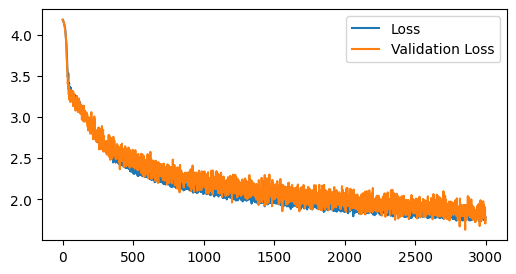

In [23]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc_out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
model = Model(emb_size=16, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")
    

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Much deeper network (20 layers)

Millions of parameters: 0.38
Epoch ___0 - Loss: 4.157 - Val Loss: 4.146
Epoch _300 - Loss: 2.995 - Val Loss: 3.036
Epoch _600 - Loss: 2.675 - Val Loss: 2.691
Epoch _900 - Loss: 2.561 - Val Loss: 2.538
Epoch 1200 - Loss: 2.489 - Val Loss: 2.515
Epoch 1500 - Loss: 2.407 - Val Loss: 2.512
Epoch 1800 - Loss: 2.386 - Val Loss: 2.438
Epoch 2100 - Loss: 2.329 - Val Loss: 2.473
Epoch 2400 - Loss: 2.334 - Val Loss: 2.419
Epoch 2700 - Loss: 2.314 - Val Loss: 2.462


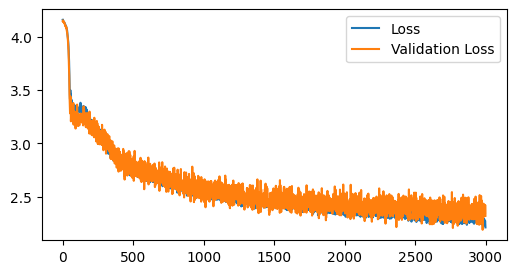

In [24]:
class Model(nn.Module):  # Same model class as before
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:
            x = F.gelu(hidden(x))
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=20).to(device)  # increased to 20 layers 
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

# Residual connections

Millions of parameters: 0.38
Epoch ___0 - Loss: 5.549
Epoch _300 - Loss: 2.200
Epoch _600 - Loss: 1.878
Epoch _900 - Loss: 1.772
Epoch 1200 - Loss: 1.655
Epoch 1500 - Loss: 1.579
Epoch 1800 - Loss: 1.551
Epoch 2100 - Loss: 1.546
Epoch 2400 - Loss: 1.448
Epoch 2700 - Loss: 1.468


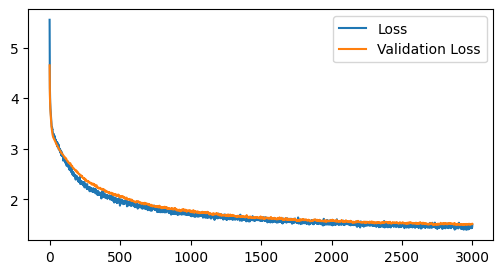

In [25]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(hidden(x))  # added skip connection 
        return self.fc_out(x)
    

model = Model(emb_size=16, hidden_size=128, n_layers=20).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In a standard layer, `x = linear(x)` completely transforms the input, which can make learning identity mappings harder. With residual connections, `x = x + linear(x)`, allowing the network to retain the original input while learning incremental changes. This improves gradient flow, facilitates identity learning, and enhances stability, especially in deep networks.

# Deeper (56 layers) 

Millions of parameters: 0.98
Epoch ___0 - Loss: 12867.733 - Val Loss: 3932.391
Epoch _300 - Loss: 3.301 - Val Loss: 3.220
Epoch _600 - Loss: 3.109 - Val Loss: 3.108
Epoch _900 - Loss: 2.979 - Val Loss: 3.037
Epoch 1200 - Loss: 2.868 - Val Loss: 2.969
Epoch 1500 - Loss: 2.785 - Val Loss: 2.908
Epoch 1800 - Loss: 2.659 - Val Loss: 2.844
Epoch 2100 - Loss: 2.590 - Val Loss: 2.789
Epoch 2400 - Loss: 2.504 - Val Loss: 2.654
Epoch 2700 - Loss: 2.413 - Val Loss: 2.611


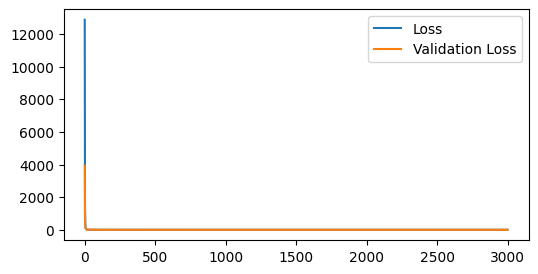

In [26]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(hidden(x))  
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)  # increased to 56 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Normalization

Deeper networks allow for more layers, but often result in high loss initially. While we previously addressed this by decreasing parameter values at initialization, going too low can cause excessively small values. To prevent this, we normalize the neurons using layer normalization, ensuring a that the model has control over mean and std

Millions of parameters: 0.99
Epoch ___0 - Loss: 4.343 - Val Loss: 4.174
Epoch _300 - Loss: 1.989 - Val Loss: 2.100
Epoch _600 - Loss: 1.667 - Val Loss: 1.670
Epoch _900 - Loss: 1.566 - Val Loss: 1.578
Epoch 1200 - Loss: 1.491 - Val Loss: 1.382
Epoch 1500 - Loss: 1.440 - Val Loss: 1.485
Epoch 1800 - Loss: 1.390 - Val Loss: 1.524
Epoch 2100 - Loss: 1.371 - Val Loss: 1.442
Epoch 2400 - Loss: 1.341 - Val Loss: 1.291
Epoch 2700 - Loss: 1.338 - Val Loss: 1.371


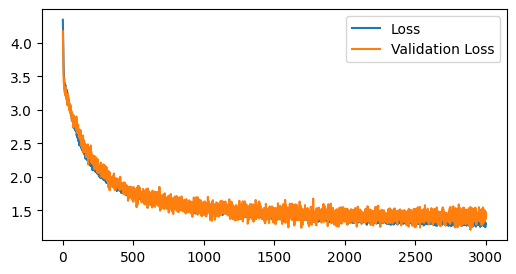

In [27]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(n_layers+1)])  # using individual norms for each layer

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for n, hidden in enumerate(self.fc_hidden): 
            x = x + F.gelu(hidden(self.norms[n](x))) 
        return self.fc_out(self.norms[-1](x)) 


model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [28]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    model.eval()
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")
    model.train()


             
KING RICHARD II:
Work you, sir? thy false.

DUCHESS OF YORK:
Then, think you, who night I cannot of her wretch murderers;
Your oath, a woman.

PETER:
A gently sorrow?

Servant:
I'ls way Juliet good wishop is sad my general Ramew the mooned of my heart
Is shepherd, 'tis my abideic from help not bears.

ROMEO:
So h

finally the text generated from the model makes some sense

# WAYY TOO DEEP
Just for fun lets try way more layers

Millions of parameters: 3.35
Epoch ___0 - Loss: 4.362 - Val Loss: 4.061
Epoch _300 - Loss: 1.959 - Val Loss: 2.015
Epoch _600 - Loss: 1.660 - Val Loss: 1.572
Epoch _900 - Loss: 1.476 - Val Loss: 1.573
Epoch 1200 - Loss: 1.392 - Val Loss: 1.390
Epoch 1500 - Loss: 1.376 - Val Loss: 1.340
Epoch 1800 - Loss: 1.387 - Val Loss: 1.352
Epoch 2100 - Loss: 1.310 - Val Loss: 1.361
Epoch 2400 - Loss: 1.316 - Val Loss: 1.508
Epoch 2700 - Loss: 1.325 - Val Loss: 1.385


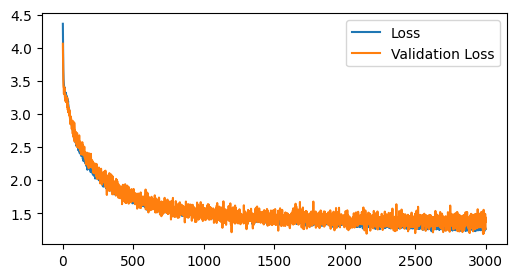

In [29]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.LayerNorm(hidden_size)  

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(hidden(self.norm(x)))  
        return self.fc_out(self.norm(x))


model = Model(emb_size=16, hidden_size=128, n_layers=200).to(device)  # increased to 200 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Limits to scale
The performance of the model is not improving in any way, it stands to reason that we are saturating the 20 character sequence length with those big models. We will now explore new ways of increasing sequence length in the next sections

# Scaling width
The number of layer is not the only way to scale. We can also make the layers wider. 
The complexity of each layer goes up with N^3 of the hidden size, but we have gpus which are extremely good at big matmuls, so we can actually increase the hidden size quite a lot before noticing it slow down

Millions of parameters: 3.33
Epoch ___0 - Loss: 4.321 - Val Loss: 3.834
Epoch _150 - Loss: 1.872 - Val Loss: 1.934
Epoch _300 - Loss: 1.637 - Val Loss: 1.657
Epoch _450 - Loss: 1.525 - Val Loss: 1.457
Epoch _600 - Loss: 1.445 - Val Loss: 1.574
Epoch _750 - Loss: 1.345 - Val Loss: 1.645
Epoch _900 - Loss: 1.303 - Val Loss: 1.579
Epoch 1050 - Loss: 1.265 - Val Loss: 1.609
Epoch 1200 - Loss: 1.210 - Val Loss: 1.526
Epoch 1350 - Loss: 1.155 - Val Loss: 1.487


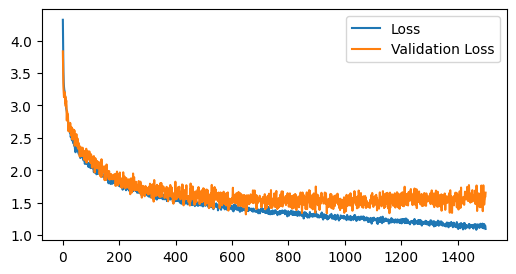

In [30]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(n_layers+1)])  # using individual norms for each layer

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for n, hidden in enumerate(self.fc_hidden): 
            x = x + F.gelu(hidden(self.norms[n](x))) 
        return self.fc_out(self.norms[-1](x)) 


model = Model(emb_size=64, hidden_size=512, n_layers=10).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 1500
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Even tho scaling the model this way seems to increase the gap between train and validation, but we are nearly getting the performance of the 56 layer MLP in less than half the time